### Clustering players

In this tutorial we show how to cluster players to positions using their statistics. We will use a dataset provided by Ronan Manning with statistics for everty top 5 leagues player

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import os
import pathlib
import json

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(4)

We open the data and change minutes played to integers. Then, we keep ony players who played more than 500 minutes. As the next step, we convert all data to numeric format and replace NaN with 0. Last but not least, we keep only columns with player statistics.

In [2]:
data = pd.read_excel("./data/fbref_data.xlsx")
data['Min'] = data.Min.astype(int)
data = data.loc[data["Min"] > 500]
data = data.reset_index(drop = True)
data = data._convert(numeric=True)
data = data.fillna(0)
X = data.iloc[:, 11:]

### First Approach - UMAP + Hierachical Clustering

Next step is to reduce dimensionality, as we have more than 100 features in this dataset. We apply standard scaling to data, then we use UMAP algorithm to reduce the dimensions to 2.

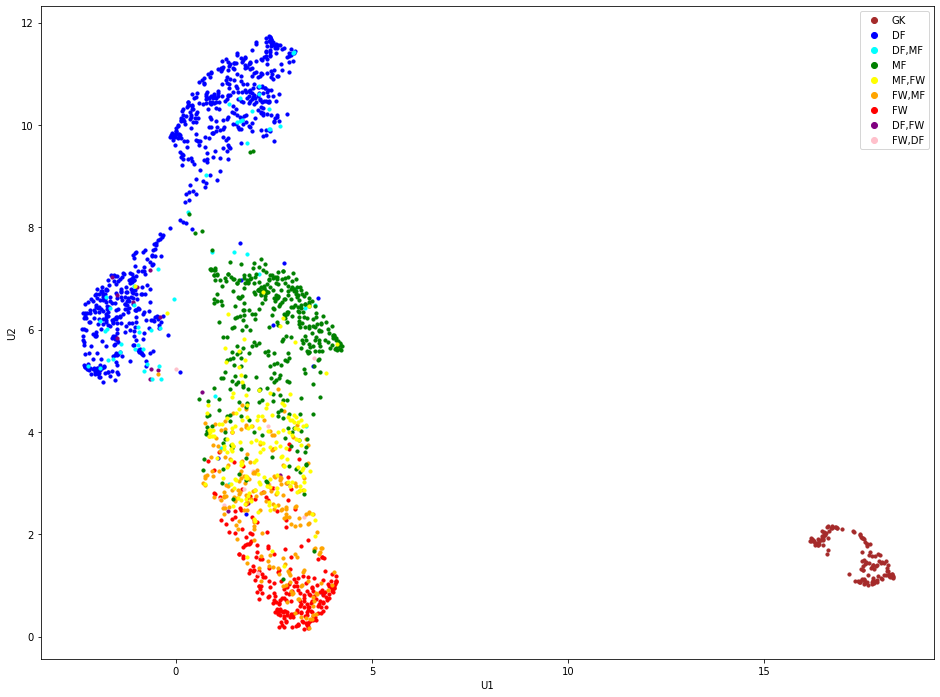

In [3]:
import umap
from sklearn.preprocessing import StandardScaler
#scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)
#dim reduction
reducer = umap.UMAP(random_state = 2213)
comps = reducer.fit_transform(X)

#plotting
fig, ax = plt.subplots(figsize = (16,12))
#map position to color
colors = {"GK": "brown", "DF": "blue", "DF,MF": "aqua", "MF": "green", "MF,FW": "yellow", "FW,MF": "orange", "FW": "red", 'DF,FW': "purple", 'FW,DF': "pink"}
color_list = data.Pos.map(colors).to_list()

#plot it
for i in range(X.shape[0]):
    ax.scatter(comps[i,0], comps[i,1], c = color_list[i], s = 10)
ax.set_xlabel('U1')
ax.set_ylabel('U2')
#make legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
ax.legend(markers, colors.keys(), numpoints=1)
plt.show()

#### Clustering

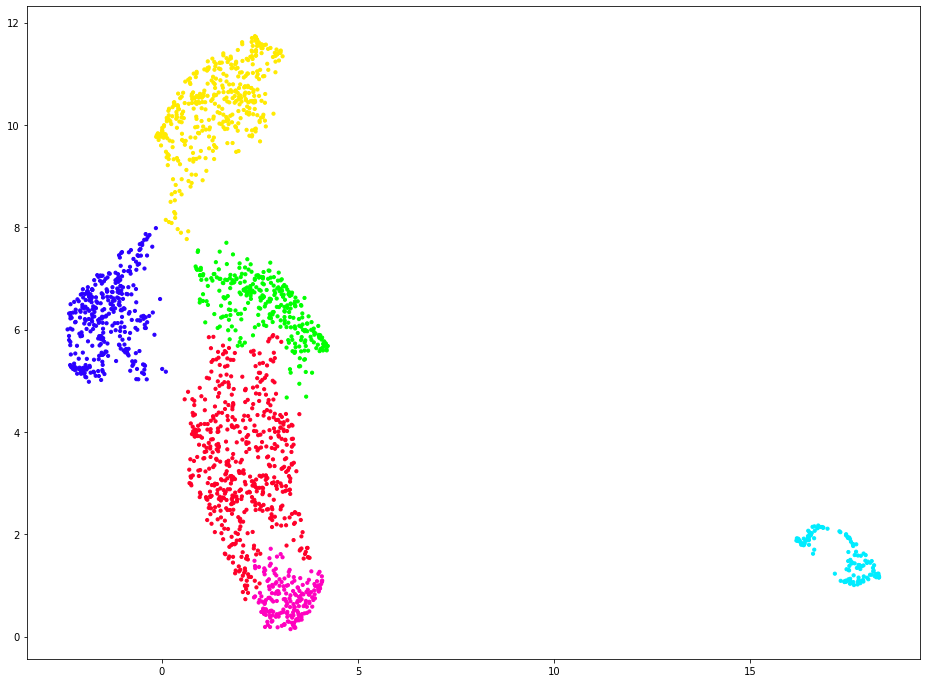

In [4]:
from sklearn.cluster import AgglomerativeClustering
#declare object
scan = AgglomerativeClustering(n_clusters=6)
#make predictions
labels = scan.fit_predict(comps)
fig, ax = plt.subplots(figsize = (16,12))
ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
plt.show()

we label them in 6 formations - goalkeepers, centre-backs, full-backs, defensive midfielders, attacking midfielders and strikers.

                   Player  Nation    Pos       Squad           Comp  label
1215        Kevin Volland  de GER  FW,MF      Monaco     fr Ligue 1      5
1197  Stephan El Shaarawy  it ITA  FW,MF        Roma     it Serie A      0
719                 Chema  es ESP  DF,MF      Getafe     es La Liga      1
1437       Marc Cucurella  es ESP     MF      Getafe     es La Liga      0
404          Pablo Maffeo  es ESP     DF      Huesca     es La Liga      4
1710  Aurélien Tchouaméni  fr FRA     MF      Monaco     fr Ligue 1      2
1878          Rade Krunić  ba BIH  MF,FW       Milan     it Serie A      0
994          Manu Vallejo  es ESP     FW    Valencia     es La Liga      5
767       Ludovic Ajorque  re REU     FW  Strasbourg     fr Ligue 1      5
356          Lukas Kübler  de GER     DF    Freiburg  de Bundesliga      4


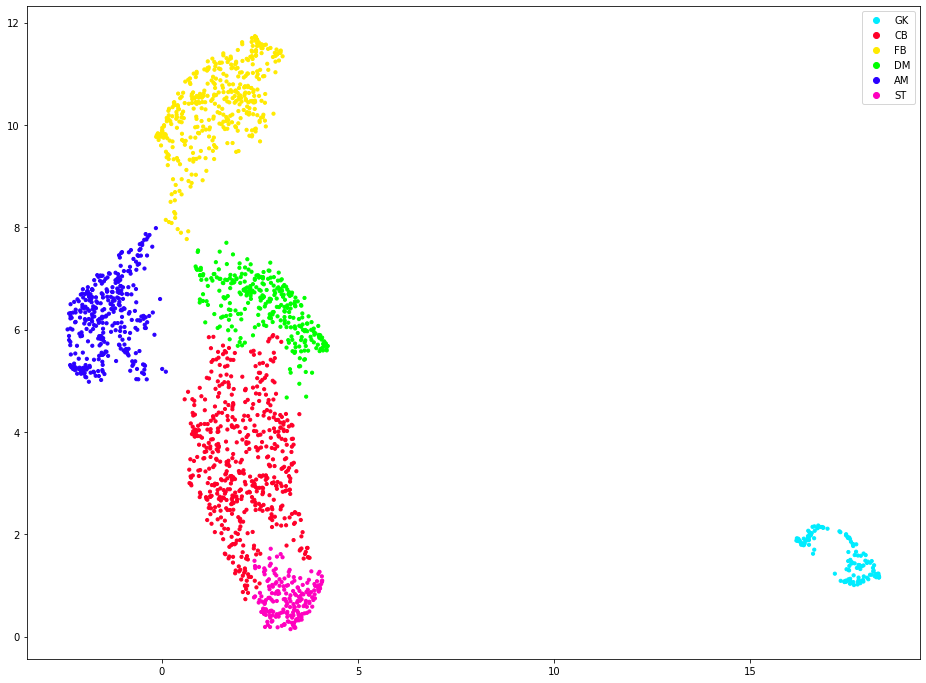

In [9]:
#explore the dataframe
see = data.iloc[:, 0:5]
see["label"] = labels
print(see.sample(frac = 1).head(10))

#plot predictions with a legend
fig, ax = plt.subplots(figsize = (16,12))
scatter = ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
handles = scatter.legend_elements()[0]
#order the labels for hierarchy
myorder = [3,0,1,2,4,5]
handles = [handles[i] for i in myorder]
#add legend
ax.legend(handles=handles, labels = ["GK", "CB", "FB", "DM", "AM", "ST"])
plt.show()

### Different Approach - PCA + tSNE + GaussianMixture

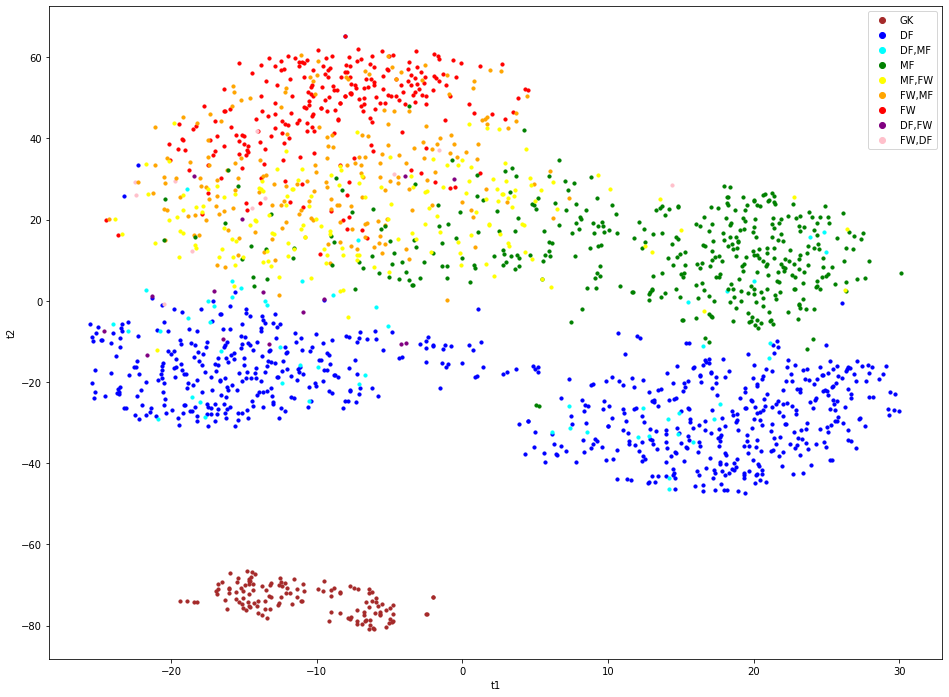

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
#declare dim reduction objects
pca = PCA()
tsne = TSNE(random_state = 3454)
#declare pipeline
ts = Pipeline([    ('pca', pca),
    ('tsne', tsne)
])
#reduce dimensions
comps = ts.fit_transform(X)
#plot it
fig, ax = plt.subplots(figsize = (16,12))
for i in range(X.shape[0]):
    ax.scatter(comps[i,0], comps[i,1], c = color_list[i], s = 10)
ax.set_xlabel('t1')
ax.set_ylabel('t2')
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
ax.legend(markers, colors.keys(), numpoints=1)
plt.show()

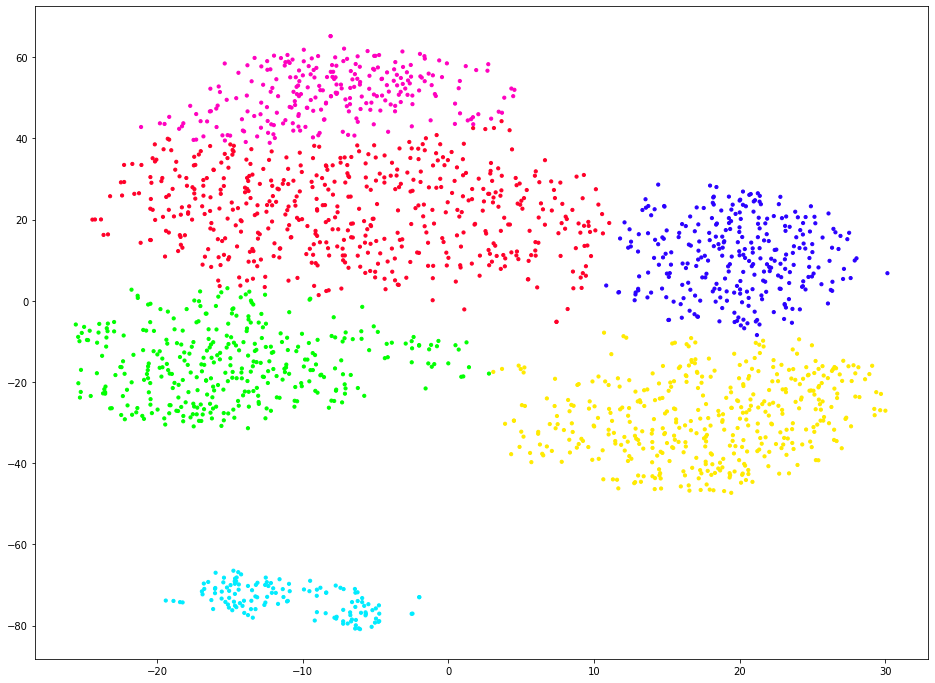

In [16]:
from sklearn.mixture import GaussianMixture
#declare object
gmm = GaussianMixture(n_components=6, random_state=5).fit(comps)
#make predictions
labels = gmm.predict(comps)
fig, ax = plt.subplots(figsize = (16,12))
plt.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
plt.show()

                 Player  Nation    Pos          Squad                Comp  \
1725     Marco Verratti  it ITA     MF      Paris S-G          fr Ligue 1   
1448        Diego Demme  de GER     MF         Napoli          it Serie A   
1170  Christian Pulisic  us USA  FW,MF        Chelsea  eng Premier League   
692          Kurt Zouma  fr FRA     DF        Chelsea  eng Premier League   
790       Karim Benzema  fr FRA     FW    Real Madrid          es La Liga   
462    Niklas Moisander  fi FIN     DF  Werder Bremen       de Bundesliga   
335   Marc-Oliver Kempf  de GER     DF      Stuttgart       de Bundesliga   
1217            Willian  br BRA  FW,MF        Arsenal  eng Premier League   
1223   Saturnin Allagbé  bj BEN     GK          Dijon          fr Ligue 1   
1505       Jonas Hector  de GER     MF           Köln       de Bundesliga   

      label  
1725      4  
1448      4  
1170      0  
692       1  
790       5  
462       1  
335       1  
1217      0  
1223      3  
1505      0 

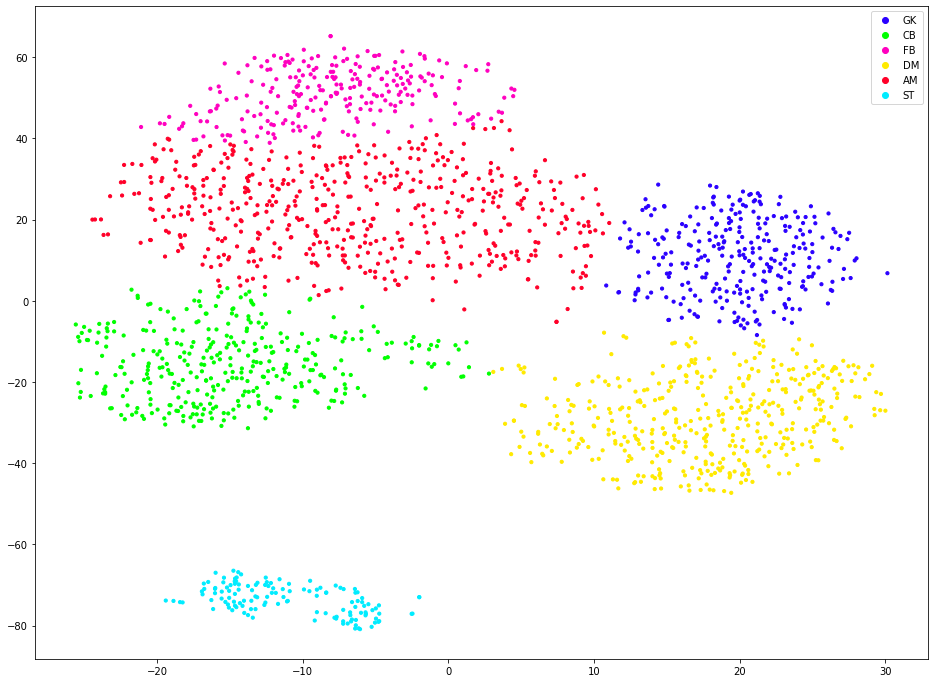

In [17]:
see = data.iloc[:, 0:5]
see["label"] = labels
print(see.sample(frac = 1).head(10))

#explore the dataframe
fig, ax = plt.subplots(figsize = (16,12))
scatter = ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
handles = scatter.legend_elements()[0]
#order the labels for hierarchy
myorder = [4,2,5,1,0,3]
handles = [handles[i] for i in myorder]
ax.legend(handles=handles, labels = ["GK", "CB", "FB", "DM", "AM", "ST"])
plt.show()